# Robust Training with Jacobinet and Adversarial Attacks

This tutorial demonstrates the use of Jacobinet for robust training in neural networks. 
Jacobinet allows the backward pass of a neural network to be represented as a neural network with shared weights. 

**Goals:**
- Understand adversarial attacks (FGSM, PGD) and their impact on model robustness.
- Use Jacobinet to implement robust training by regularizing against adversarial examples.
- Evaluate robustness with AutoAttack for both baseline and robust training.

We will:
1. Train a baseline model and evaluate its adversarial robustness.
2. Train a robust model with adversarial regularization using Jacobinet.
3. Compare adversarial success rates for both models.


- When running this notebook on Colab, we need to install *decomon* if on Colab. 
- If you run this notebook locally, do it inside the environment in which you [installed *jacobinet*](https://ducoffeM.github.io/jacobinet/main/install.html).

In [1]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import sys  # noqa: avoid having this import removed by pycln

    # install dev version for dev doc, or release version for release doc
    !{sys.executable} -m pip install -U pip
    !{sys.executable} -m pip install git+https://github.com/ducoffeM/jacobinet@main#egg=decomon
    # install desired backend (by default torch)
    !{sys.executable} -m pip install "torch"
    !{sys.executable} -m pip install "keras"

    # extra librabry used in this notebook
    !{sys.executable} -m pip install "torchattacks"
    !{sys.executable} -m pip install "numpy"
    !{sys.executable} -m pip install "matplotlib"
    

## Load and Preprocess Data

We will use the MNIST dataset for this tutorial. The dataset is normalized to the [0, 1] range and reshaped for compatibility with the convolutional model.


In [3]:
import keras
import numpy as np
import matplotlib.pyplot as plt

import torch

# Load the MNIST data and split it into training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the images to the [0, 1] range
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.

# Reshape images to have an additional channel dimension (1, 28, 28)
x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)

# Convert class labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


## Define and Train the Baseline Model

We will build a simple Convolutional Neural Network (CNN) using Keras to serve as the baseline model. 
This model will be trained on MNIST and evaluated for accuracy on clean data.


In [4]:
from keras import layers, Sequential

# Define the model architecture


model = Sequential(
    [
        layers.Input(shape=(1, 28, 28)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(10)
    ]
)
model.summary()


train_model = Sequential(model.layers + [layers.Activation('softmax')])

train_model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=["accuracy"])


model.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])

train_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 26, 26)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 24, 24)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │       368,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,218 (1.55 MB)

 Trainable params: 406,218 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2


NotImplementedError: The operator 'aten::_foreach_mul_.Scalar' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [3]:
train_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1)

## Evaluate Robustness of Baseline Model

We use AutoAttack, a strong adversarial attack framework, to test the baseline model's robustness. 
AutoAttack generates adversarial examples by varying the attack radius (`epsilon`), and we measure the model's accuracy on these examples.


In [122]:
import torchattacks
import torch

# Test robustness at different epsilon values
n = 200
random_index = np.random.permutation(len(x_test))[:n]
adv_acc = []
eps_values = [np.round(eps_i, 2) for eps_i in np.linspace(0.01, 0.2, 10)]
eps_values = [0.1]
eps = 0.1
#for eps in eps_values:
for i in range(100):
    random_index = np.arange(100)+i*100
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data, verbose=0).argmax(-1) != y_test[random_index].argmax(-1))[0]) / len(random_index) * 100
    adv_acc.append(acc)
    print(adv_acc)
print(acc)

plt.plot(eps_values, adv_acc)
plt.title('Distribution of adversarial success rates with baseline training')
plt.xlabel('Epsilon (attack radius)')
plt.ylabel('Adversarial success rate')


[2.0]
[2.0, 2.0]
[2.0, 2.0, 1.0]
[2.0, 2.0, 1.0, 3.0]
[2.0, 2.0, 1.0, 3.0, 1.0]
[2.0, 2.0, 1.0, 3.0, 1.0, 2.0]
[2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 3.0]
[2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 3.0, 2.0]
[2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0]
[2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 4.0]
[2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 4.0, 3.0]


KeyboardInterrupt: 

In [84]:
data = np.unique(np.abs((adv_data.cpu().detach().numpy() - x_test[random_index]).flatten()))

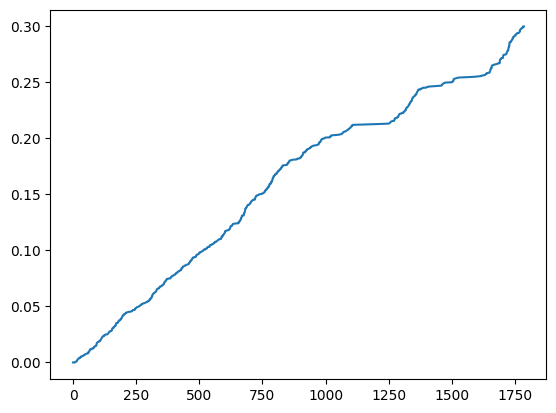

In [87]:
plt.plot(data)

## Robust Training with Jacobinet

To improve robustness, we will train a model that outputs predictions for both clean and adversarial examples. 
Jacobinet is used to create adversarial examples with Projected Gradient Descent (PGD), which are integrated into the training process.


In [112]:
from jacobinet.attacks import get_adv_model


pgd_model = get_adv_model(model, loss='logits', epsilon=1e-2, attack='pgd', n_iter=20) # think of clipping

x = layers.Input(shape=(1, 28, 28))
y = layers.Input((10,))

model_adv = keras.models.Model([x, y], [model(x), model(pgd_model([x, y]))])
model_adv.compile('adam',
                  loss=[keras.losses.CategoricalCrossentropy(from_logits=True),
                        keras.losses.CategoricalCrossentropy(from_logits=True)],
                  metrics=['accuracy', 'accuracy'], loss_weights=[1, 100])



In [115]:
model_adv.fit([x_train, y_train], [y_train, y_train], batch_size=32, epochs=50, validation_split=0.1, shuffle=True)


Epoch 1/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 877s 520ms/step - loss: 2.7385 - sequential_10_accuracy: 0.9999 - sequential_10_accuracy_1: 0.9904 - sequential_10_loss: 0.0274 - val_loss: 17.8805 - val_sequential_10_accuracy: 0.9932 - val_sequential_10_accuracy_1: 0.9647 - val_sequential_10_loss: 0.1785
Epoch 2/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 891s 528ms/step - loss: 2.5438 - sequential_10_accuracy: 0.9998 - sequential_10_accuracy_1: 0.9908 - sequential_10_loss: 0.0254 - val_loss: 15.2358 - val_sequential_10_accuracy: 0.9930 - val_sequential_10_accuracy_1: 0.9700 - val_sequential_10_loss: 0.1520
Epoch 3/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 932s 552ms/step - loss: 2.4664 - sequential_10_accuracy: 0.9998 - sequential_10_accuracy_1: 0.9909 - sequential_10_loss: 0.0247 - val_loss: 25.0506 - val_sequential_10_accuracy: 0.9937 - val_sequential_10_accuracy_1: 0.9510 - val_sequential_10_loss: 0.2502
Epoch 4/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 884s 524ms/step - loss: 2.4017 - sequential_10_accuracy: 0.99

KeyboardInterrupt: 

In [6]:
import torchattacks
import torch
auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=0.2)
acc_batch = []
for i in range(10):
    batch = i + np.arange(100)
    adv_data_robust = auto_attack(torch.Tensor(x_test[batch]), torch.tensor(y_test[batch].argmax(-1)))
    acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1) != y_test[batch].argmax(-1))[0]) / len(batch) * 100
    print(acc)
    acc_batch.append(acc)


13.0


KeyboardInterrupt: 

## Evaluate Robustness of Robust Model

We use AutoAttack again to evaluate the robust model under varying attack radii. 
This allows us to compare the adversarial success rates of the baseline and robust models.


In [ ]:
adv_acc_robust = []

for eps in eps_values:
    print(eps)
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data_robust = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1) != y_test[random_index].argmax(-1))[0]) / len(random_index) * 100
    adv_acc_robust.append(acc)

plt.plot(eps_values, adv_acc, label='Baseline Training')
plt.plot(eps_values, adv_acc_robust, label='Robust Training')
plt.title('Adversarial Success Rates: Baseline vs. Robust Training')
plt.xlabel('Epsilon (attack radius)')
plt.ylabel('Adversarial success rate')
plt.legend()


## Conclusion

In this tutorial, we explored the use of Jacobinet for robust training against adversarial attacks. Key takeaways include:
1. Baseline models are vulnerable to adversarial examples, as shown by the high adversarial success rates.
2. Robust training with Jacobinet significantly improves resistance to adversarial attacks.
3. This workflow can be extended to other datasets and adversarial attack frameworks.

Jacobinet's ability to treat the backward pass as a neural network opens exciting possibilities for research in robustness and adversarial machine learning.
